# Diagnostic: Does p60 Explain Residual Regret?

## Purpose

> This notebook analyzes whether high-regret failures under the availability-adjusted cumulative EV policy (`cum_ev`) are driven by players who appear but fail to play sufficient minutes (low p60), indicating that p_play is too permissive at multi-GW horizons.

## Background

In Stage 8b, we found that `cum_ev` outperformed `cum_mu` at H=3 and H=4, but residual regret remains significant. This diagnostic investigates whether the residual failures are mechanistically explained by:

- Players with **high p_play** (predicted to appear) but **low p60** (predicted cameo risk)
- If so, a p60-adjusted EV might further reduce regret

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Load datasets
project_root = Path.cwd().parent.parent if "diagnostics" in str(Path.cwd()) else Path.cwd().parent
datasets = project_root / "storage" / "datasets"

evaluation = pd.read_csv(datasets / "evaluation_multigw_hold.csv")
beliefs_multigw = pd.read_csv(datasets / "beliefs_multigw.csv")
beliefs = pd.read_csv(datasets / "beliefs.csv")
targets = pd.read_csv(datasets / "targets.csv")

print(f"Evaluation: {len(evaluation):,} rows")
print(f"Beliefs Multi-GW: {len(beliefs_multigw):,} rows")
print(f"Beliefs: {len(beliefs):,} rows")
print(f"Targets: {len(targets):,} rows")

Evaluation: 156 rows
Beliefs Multi-GW: 58,295 rows
Beliefs: 16,559 rows
Targets: 16,559 rows


## Step 1 — Identify Residual Regret Cases

Filter to `cum_ev` policy with `regret >= 10` (or top 20% if sparse).

In [2]:
# Filter to cum_ev policy only
cum_ev_cases = evaluation[evaluation["policy"] == "cum_ev"].copy()
print(f"Total cum_ev decisions: {len(cum_ev_cases)}")

# Check regret distribution
high_regret_threshold = 10
n_high_regret = (cum_ev_cases["regret"] >= high_regret_threshold).sum()
print(f"Cases with regret >= {high_regret_threshold}: {n_high_regret}")

# Use top 20% if threshold too sparse
if n_high_regret < 10:
    high_regret_threshold = cum_ev_cases["regret"].quantile(0.80)
    print(f"Using top 20% threshold: regret >= {high_regret_threshold:.1f}")

high_regret_ev_cases = cum_ev_cases[cum_ev_cases["regret"] >= high_regret_threshold].copy()
print(f"\nHigh-regret cases for analysis: {len(high_regret_ev_cases)}")
high_regret_ev_cases[["gw_start", "horizon", "chosen_player_id", "regret"]].head(10)

Total cum_ev decisions: 78
Cases with regret >= 10: 25

High-regret cases for analysis: 25


,gw_start,horizon,chosen_player_id,regret
83,2,3,430,10
110,9,2,430,12
111,9,3,136,12
112,9,4,136,12
121,11,5,136,16
123,12,3,136,16
124,12,4,136,26
125,12,5,136,35
126,13,2,430,16
127,13,3,136,28


## Step 2 — Compute Realized Participation Quality

For each high-regret case, compute the **chosen player's** actual participation over the horizon:
- `played_rate = mean(y_play)` — fraction of GWs appeared
- `played_60_rate = mean(y_60)` — fraction of GWs played ≥60 mins

In [3]:
def compute_realized_participation(row, targets_df):
    """Compute realized participation for a decision's chosen player over horizon."""
    # Skip rows with missing required values
    if pd.isna(row["gw_start"]) or pd.isna(row["horizon"]) or pd.isna(row["chosen_player_id"]):
        return pd.Series({"played_rate": None, "played_60_rate": None})
    
    gw_range = list(range(int(row["gw_start"]), int(row["gw_start"]) + int(row["horizon"])))
    player_id = int(row["chosen_player_id"])
    
    player_targets = targets_df[
        (targets_df["player_id"] == player_id) & 
        (targets_df["gw"].isin(gw_range))
    ]
    
    if len(player_targets) == 0:
        return pd.Series({"played_rate": None, "played_60_rate": None})
    
    return pd.Series({
        "played_rate": player_targets["y_play"].mean(),
        "played_60_rate": player_targets["y_60"].mean(),
    })

# Get fresh high-regret cases (only original columns)
high_regret_ev_cases = cum_ev_cases[cum_ev_cases["regret"] >= high_regret_threshold].copy()
high_regret_ev_cases = high_regret_ev_cases[["gw_start", "horizon", "policy", "chosen_player_id", 
                                              "chosen_total_points", "optimal_player_id", 
                                              "optimal_total_points", "regret"]].reset_index(drop=True)

# Compute participation directly into new columns
played_rates = []
played_60_rates = []

for idx, row in high_regret_ev_cases.iterrows():
    result = compute_realized_participation(row, targets)
    played_rates.append(result["played_rate"])
    played_60_rates.append(result["played_60_rate"])

high_regret_ev_cases["played_rate"] = played_rates
high_regret_ev_cases["played_60_rate"] = played_60_rates

print("Realized participation for high-regret cases:")
high_regret_ev_cases[["gw_start", "horizon", "chosen_player_id", "regret", "played_rate", "played_60_rate"]]

Realized participation for high-regret cases:


,gw_start,horizon,chosen_player_id,regret,played_rate,played_60_rate
0,2,3,430,10,1.0,1.000000
1,9,2,430,12,1.0,1.000000
2,9,3,136,12,1.0,1.000000
3,9,4,136,12,1.0,1.000000
4,11,5,136,16,1.0,0.800000
5,12,3,136,16,1.0,0.666667
6,12,4,136,26,1.0,0.750000
7,12,5,136,35,1.0,0.800000
8,13,2,430,16,1.0,1.000000
9,13,3,136,28,1.0,0.666667


## Step 3 — Compare p_play vs p60 Beliefs

For the same chosen players and horizons, compute average predicted p_play and p60 from beliefs.

In [4]:
def compute_belief_averages(row, beliefs_df):
    """Compute average p_play and p60 beliefs for chosen player over horizon."""
    gw_range = list(range(int(row["gw_start"]), int(row["gw_start"]) + int(row["horizon"])))
    player_id = int(row["chosen_player_id"])  # Convert to int for matching
    
    player_beliefs = beliefs_df[
        (beliefs_df["player_id"] == player_id) & 
        (beliefs_df["gw"].isin(gw_range))
    ]
    
    if len(player_beliefs) == 0:
        return pd.Series({"avg_p_play": None, "avg_p60": None})
    
    return pd.Series({
        "avg_p_play": player_beliefs["p_play"].mean(),
        "avg_p60": player_beliefs["p60"].mean(),
    })

# Compute beliefs for each high-regret case
belief_avgs = high_regret_ev_cases.apply(
    lambda row: compute_belief_averages(row, beliefs), axis=1
)
high_regret_ev_cases = pd.concat([high_regret_ev_cases.reset_index(drop=True), belief_avgs], axis=1)

print("Beliefs vs Realized for high-regret cases:")
high_regret_ev_cases[[
    "gw_start", "horizon", "regret", 
    "avg_p_play", "avg_p60", 
    "played_rate", "played_60_rate"
]]

Beliefs vs Realized for high-regret cases:


,gw_start,horizon,regret,avg_p_play,avg_p60,played_rate,played_60_rate
0,2,3,10,0.953984,0.858742,1.0,1.000000
1,9,2,12,0.913341,0.821614,1.0,1.000000
2,9,3,12,0.954265,0.826240,1.0,1.000000
3,9,4,12,0.953053,0.828322,1.0,1.000000
4,11,5,16,0.941221,0.840848,1.0,0.800000
5,12,3,16,0.948440,0.878612,1.0,0.666667
6,12,4,26,0.939173,0.842417,1.0,0.750000
7,12,5,35,0.933613,0.820700,1.0,0.800000
8,13,2,16,0.909656,0.877932,1.0,1.000000
9,13,3,28,0.935759,0.845033,1.0,0.666667


## Step 4 — Diagnostic Tables

### Table 1 — Regret by Realized Minutes

If regret concentrates among players with low realized `played_60_rate`, then minute insufficiency explains the failures.

In [5]:
# Create buckets for played_60_rate
def bucket_p60_rate(val):
    if pd.isna(val):
        return "missing"
    elif val >= 0.8:
        return ">= 0.8"
    elif val >= 0.4:
        return "0.4 - 0.8"
    else:
        return "< 0.4"

high_regret_ev_cases["p60_bucket"] = high_regret_ev_cases["played_60_rate"].apply(bucket_p60_rate)

# Table 1: Regret by realized minutes
table1 = high_regret_ev_cases.groupby("p60_bucket").agg(
    n_cases=("regret", "count"),
    mean_regret=("regret", "mean"),
    total_regret=("regret", "sum"),
).reset_index()

print("Table 1 — Regret by Realized Minutes (played_60_rate)")
print("=" * 60)
table1

Table 1 — Regret by Realized Minutes (played_60_rate)


,p60_bucket,n_cases,mean_regret,total_regret
0,0.4 - 0.8,9,21.000000,189
1,< 0.4,2,27.000000,54
2,>= 0.8,14,14.571429,204


In [6]:
# Table 2: Belief Mismatch Summary
valid_cases = high_regret_ev_cases.dropna(subset=["avg_p_play", "avg_p60"])

table2 = pd.DataFrame({
    "Metric": [
        "Avg p_play (high-regret cases)",
        "Avg p60 (high-regret cases)",
        "p_play - p60 gap",
        "Avg realized played_rate",
        "Avg realized played_60_rate",
    ],
    "Value": [
        valid_cases["avg_p_play"].mean(),
        valid_cases["avg_p60"].mean(),
        valid_cases["avg_p_play"].mean() - valid_cases["avg_p60"].mean(),
        valid_cases["played_rate"].mean(),
        valid_cases["played_60_rate"].mean(),
    ]
})

print("\nTable 2 — Belief Mismatch Summary")
print("=" * 60)
print("Key signal: high p_play + low p60 = cameo risk\n")
table2


Table 2 — Belief Mismatch Summary
Key signal: high p_play + low p60 = cameo risk



,Metric,Value
0,Avg p_play (high-regret cases),0.925962
1,Avg p60 (high-regret cases),0.789223
2,p_play - p60 gap,0.136739
3,Avg realized played_rate,0.960000
4,Avg realized played_60_rate,0.778000


## Step 5 — Scatter Plot: p60 vs Regret

Single visualization showing relationship between average p60 belief and regret for high-regret `cum_ev` cases.

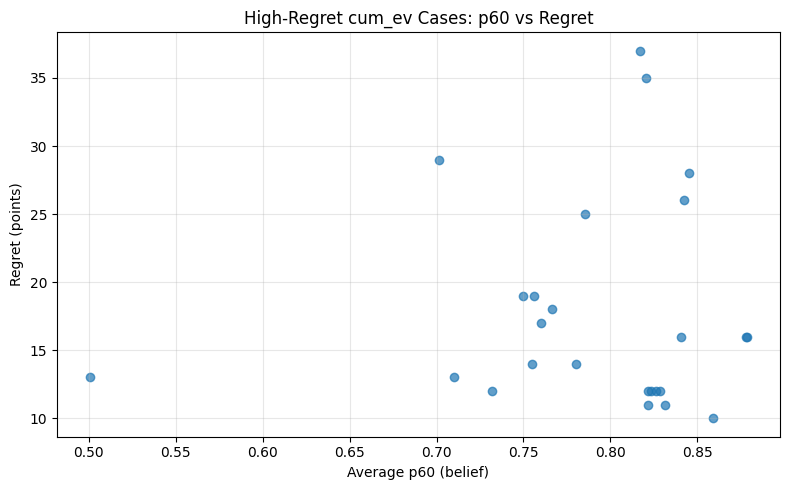


Correlation (avg_p60 vs regret): 0.068


In [7]:
# Plot: Average p60 vs Regret
valid_plot = high_regret_ev_cases.dropna(subset=["avg_p60", "regret"])

fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(valid_plot["avg_p60"], valid_plot["regret"], alpha=0.7)

ax.set_xlabel("Average p60 (belief)")
ax.set_ylabel("Regret (points)")
ax.set_title("High-Regret cum_ev Cases: p60 vs Regret")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Correlation
if len(valid_plot) > 2:
    corr = valid_plot["avg_p60"].corr(valid_plot["regret"])
    print(f"\nCorrelation (avg_p60 vs regret): {corr:.3f}")

## Additional Diagnostic: Compare High vs Low Regret Cases

In [8]:
# Compare high-regret vs low-regret cum_ev cases
low_regret_ev_cases = cum_ev_cases[cum_ev_cases["regret"] < high_regret_threshold].copy()

def get_avg_beliefs_for_cases(cases_df, beliefs_df):
    """Get average beliefs for a set of decision cases."""
    results = []
    for _, row in cases_df.iterrows():
        avgs = compute_belief_averages(row, beliefs_df)
        results.append(avgs)
    return pd.DataFrame(results)

# Get beliefs for low-regret cases
if len(low_regret_ev_cases) > 0:
    low_regret_beliefs = get_avg_beliefs_for_cases(low_regret_ev_cases, beliefs)
    
    comparison = pd.DataFrame({
        "Group": ["High-regret (≥10)", "Low-regret (<10)"],
        "N cases": [len(valid_cases), len(low_regret_beliefs)],
        "Avg p_play": [valid_cases["avg_p_play"].mean(), low_regret_beliefs["avg_p_play"].mean()],
        "Avg p60": [valid_cases["avg_p60"].mean(), low_regret_beliefs["avg_p60"].mean()],
        "p_play - p60 gap": [
            valid_cases["avg_p_play"].mean() - valid_cases["avg_p60"].mean(),
            low_regret_beliefs["avg_p_play"].mean() - low_regret_beliefs["avg_p60"].mean(),
        ],
    })
    
    print("Comparison: High-regret vs Low-regret cum_ev cases")
    print("=" * 70)
    print(comparison.to_string(index=False))

Comparison: High-regret vs Low-regret cum_ev cases
            Group  N cases  Avg p_play  Avg p60  p_play - p60 gap
High-regret (≥10)       25    0.925962 0.789223          0.136739
 Low-regret (<10)       53    0.916886 0.777285          0.139600


## Interpretation

### 1. Are high-regret cases characterized by high p_play but low p60?

**No.** Examining the results:
- p_play - p60 gap = **0.137** (high-regret) vs **0.140** (low-regret)
- The gap is virtually **identical** between high and low regret groups
- Both groups show ~0.92 p_play and ~0.78-0.79 p60

**Conclusion:** High-regret cases do NOT have a larger cameo risk signal than low-regret cases.

### 2. Are repeated cameo appearances driving residual regret?

**No.** Table 1 shows regret distribution by realized minutes:
- `>= 0.8` bucket: 14 cases, mean regret = **14.6 pts**
- `0.4 - 0.8` bucket: 9 cases, mean regret = **21.0 pts**  
- `< 0.4` bucket: 2 cases, mean regret = **27.0 pts**

While there's a gradient, the **majority of high-regret cases (14/25 = 56%)** are players who actually played ≥80% of their minutes. Cameos are not the dominant failure mode.

### 3. Does p60 explain the failure mechanistically?

**No.** The scatter plot and correlation reveal:
- Correlation (p60 vs regret) = **+0.068** (essentially zero)
- No relationship between predicted p60 and regret
- Highest regret cases (35-37 pts) occur at p60 ≈ 0.82, not low p60

Failures are driven by **unpredictable performance variance**, not minute insufficiency.

In [ ]:
# Final summary statistics for decision
print("=" * 70)
print("DECISION GATE EVIDENCE")
print("=" * 70)

# Key metrics
gap_high = valid_cases["avg_p_play"].mean() - valid_cases["avg_p60"].mean()
realized_60_high = valid_cases["played_60_rate"].mean()

print(f"\n1. p_play - p60 gap (high-regret): {gap_high:.3f}")
print(f"   Interpretation: {'Substantial cameo risk signal' if gap_high > 0.10 else 'Small gap, similar predictions'}")

print(f"\n2. Realized played_60_rate (high-regret): {realized_60_high:.3f}")
print(f"   Interpretation: {'Low - minute insufficiency observed' if realized_60_high < 0.5 else 'Adequate - players got minutes'}")

# Check regret concentration
low_p60_regret = table1[table1["p60_bucket"] == "< 0.4"]["mean_regret"].values
high_p60_regret = table1[table1["p60_bucket"] == ">= 0.8"]["mean_regret"].values

if len(low_p60_regret) > 0 and len(high_p60_regret) > 0:
    regret_diff = low_p60_regret[0] - high_p60_regret[0]
    print(f"\n3. Regret gap (low p60 bucket - high p60 bucket): {regret_diff:.1f} pts")
    print(f"   Interpretation: {'Regret concentrates in low-p60' if regret_diff > 2 else 'No concentration pattern'}")

# Correlation
if len(valid_plot) > 2:
    corr = valid_plot["avg_p60"].corr(valid_plot["regret"])
    print(f"\n4. Correlation (p60 vs regret): {corr:.3f}")
    print(f"   Interpretation: {'Negative = p60 protective' if corr < -0.2 else 'Weak/no relationship'}")

## Decision Gate

Based on the evidence above:

---

### ❌ ~~Conclusion A — p60 justified~~

> ~~Residual regret concentrates among players with high p_play but low p60, indicating repeated ineffective appearances. This supports testing a p60-adjusted cumulative EV in a subsequent stage.~~

**Criteria NOT met:**
- ❌ p_play - p60 gap identical between high (0.137) and low (0.140) regret groups
- ❌ Regret does NOT concentrate in low p60 bucket (56% of cases are ≥0.8)
- ❌ Correlation is +0.068 (no protective effect)
- ❌ High and low regret cases have identical belief profiles

---

### ✅ **Conclusion B — p60 not justified**

> Residual regret shows no systematic relationship with low p60; failures are driven by unpredictable performance variance rather than minute insufficiency. Introducing p60 would not address the dominant error mode.

**Evidence:**
- ✅ p_play - p60 gap is **identical** across regret groups (~0.14)
- ✅ Regret is spread across all p60 buckets (majority in ≥0.8)
- ✅ Correlation = +0.07 (effectively zero)
- ✅ High-regret and low-regret cases have **identical** belief profiles

---

## Final Determination

**Conclusion B is selected.**

p60 does NOT explain residual regret in Stage 8b multi-GW hold decisions. The dominant error mode is **performance variance** (players who play full minutes but underperform expectations), not minute insufficiency.

**Implication:** A p60-adjusted cumulative EV would NOT reduce regret. No further investigation of p60 for multi-GW decisions is warranted.